# Working with Joins

## Imports

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

## SparkSession

In [2]:
spark = ( SparkSession
         .builder
         .getOrCreate())

## Load the data

Load the Chicago reported crimes dataset.

In [3]:
# Set display for scrolling dataframes
from IPython.core.display import HTML
display(HTML("<style>pre {white-space: pre !important; }</style>"))

In [4]:
import os
from pyspark.sql.functions import to_timestamp, col, lit

data_path = 'file:///' + os.getcwd() + '/data'

file_path = data_path + '/reported-crimes.csv'

crimes_df = (
    spark.read
    .option("header", "true")
    .csv(file_path)
    .withColumn("Date", to_timestamp(col("Date"), "M/d/y h:m:s a"))
    .filter(col("Date") <= lit("2018-11-11"))
)

crimes_df.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

## Download police station data

In addition to the reported crimes dataset, we are going to download the police station dataset from the city of Chicago Data Portal. The data can be downloaded on the commandline using wget:

`$ !wget -O data/police-stations.csv 'https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD'`

In [5]:
!wget -O data/police-stations.csv 'https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD'

--2021-10-18 15:26:00--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.205, 52.206.140.199, 52.206.68.26, ...
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/police-stations.csv’

data/police-station     [ <=>                ]   5.57K  --.-KB/s    in 0s      

2021-10-18 15:26:05 (532 MB/s) - ‘data/police-stations.csv’ saved [5699]



In [6]:
!ls data/

police-stations.csv  reported-crimes.csv


In [7]:
file_path = data_path + '/police-stations.csv'

police_station_df = (
    spark.read
    .csv(file_path, header=True)
)

police_station_df.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

**The reported crimes dataset has only one district number. Add the district name by joining with the police station dataset**

In [8]:
# crimes_df.cache()
# crimes_df.count()

In [9]:
police_station_df.select(col('District')).distinct().show(5)

+--------+
|District|
+--------+
|       7|
|      15|
|      11|
|       3|
|       8|
+--------+
only showing top 5 rows



In [10]:
crimes_df.select('District').distinct().show(5)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|    null|
|     031|
+--------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import lpad

In [12]:
police_station_df.select(lpad(col('District'), 3, '0')).show(30)

+--------------------+
|lpad(District, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
|                 014|
|                 015|
|                 016|
|                 017|
+--------------------+



In [13]:
police_station_df = (police_station_df.
                     withColumn('Format_district', 
                                lpad(col('District'), 3, '0')))

In [14]:
police_station_df.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [15]:
crimes_df.join(
    police_station_df, 
    crimes_df.District == police_station_df.Format_district, 
    'left_outer').show(10)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+-------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT|DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district

In [16]:
police_station_df.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [17]:
drop_columns = [
     'ADDRESS',
     'CITY',
     'STATE',
     'ZIP',
     'WEBSITE',
     'PHONE',
     'FAX',
     'TTY',
     'X COORDINATE',
     'Y COORDINATE',
     'LATITUDE',
     'LONGITUDE',
     'LOCATION']

In [18]:
(crimes_df.join(
    police_station_df, 
    crimes_df.District == police_station_df.Format_district, 
    'left_outer')
     .drop(*drop_columns)
     .show(5))

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT|DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+-------------+---------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|            61|     08B|2015|02/10/2018 03:50:...|       9|      Deering|            009|
|1022473

## Challenge Questions

**What is the most frequently reported non-criminal activity?**

In [19]:
crimes_df.select(col('Primary Type')).distinct().count()

36

In [20]:
(
    crimes_df
        .select(col('Primary Type'))
        .distinct()
        .orderBy(col('Primary Type'))
        .show(36, truncate=False))

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [21]:
non_criminal_df = crimes_df.filter(
    (col('Primary Type') == 'NON - CRIMINAL') |
    (col('Primary Type') == 'NON-CRIMINAL') |
    (col('Primary Type') == 'NON-CRIMINAL (SUBJECT SPECIFIED)')
)

non_criminal_df.show(10)

+--------+-----------+-------------------+--------------------+----+--------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|  Primary Type|      Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------+-----------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10233370|   HY421530|2015-09-13 10:45:00|  010XX S MENARD AVE|5114|NON - CRIMINAL|FOID - REVOCATION|           RESIDENCE|  true|   false|1513|     015|  

In [22]:
(
    non_criminal_df
    .groupBy(col('Description'))
    .count()
    .orderBy('count', ascending=False)
    .show(truncate=False))

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |107  |
|FOID - REVOCATION                          |75   |
|NOTIFICATION OF CIVIL NO CONTACT ORDER     |9    |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|8    |
|FOUND PASSPORT                             |4    |
|CONCEALED CARRY LICENSE REVOCATION         |4    |
|GUN OFFENDER NOTIFICATION-NO CONTACT       |3    |
+-------------------------------------------+-----+



**Which day of the week has the most number of reported crime?**

In [23]:
from pyspark.sql.functions import dayofweek

In [24]:
crimes_df.show(5)

+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|2015-09-05 13:30:00|     043XX S WOOD ST|0486|     BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     00

In [25]:
(crimes_df
     .select(col('Date'), dayofweek(col('Date')))
     .show(5))

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2015-09-05 13:30:00|              7|
|2015-09-04 11:30:00|              6|
|2018-09-01 00:01:00|              7|
|2015-09-05 12:45:00|              7|
|2015-09-05 13:00:00|              7|
+-------------------+---------------+
only showing top 5 rows



In [26]:
from pyspark.sql.functions import date_format

In [27]:
(
    crimes_df
        .select(col('Date'), dayofweek(col('Date')), date_format(col('Date'), 'E'))
        .show(5)
)

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2015-09-05 13:30:00|              7|                 Sat|
|2015-09-04 11:30:00|              6|                 Fri|
|2018-09-01 00:01:00|              7|                 Sat|
|2015-09-05 12:45:00|              7|                 Sat|
|2015-09-05 13:00:00|              7|                 Sat|
+-------------------+---------------+--------------------+
only showing top 5 rows



In [28]:
(
    crimes_df.groupBy(date_format(col('Date'), 'E'))
        .count()
        .orderBy('count', ascending=False)
        .show()
)

+--------------------+-------+
|date_format(Date, E)|  count|
+--------------------+-------+
|                 Fri|1017163|
|                 Wed| 974077|
|                 Tue| 968227|
|                 Sat| 965351|
|                 Thu| 964771|
|                 Mon| 952927|
|                 Sun| 912143|
+--------------------+-------+



In [29]:
day_counts = (crimes_df
    .groupBy(date_format(col('Date'), 'E'))
    .count()
    .collect())

day_counts

[Row(date_format(Date, E)='Sun', count=912143),
 Row(date_format(Date, E)='Mon', count=952927),
 Row(date_format(Date, E)='Thu', count=964771),
 Row(date_format(Date, E)='Sat', count=965351),
 Row(date_format(Date, E)='Wed', count=974077),
 Row(date_format(Date, E)='Fri', count=1017163),
 Row(date_format(Date, E)='Tue', count=968227)]

In [30]:
dow = [x[0] for x in day_counts]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [31]:
cnt = [x[1] for x in day_counts]
cnt

[912143, 952927, 964771, 965351, 974077, 1017163, 968227]

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

count_df = pd.DataFrame({
    'Day_of_week': dow,
    'Count': cnt
})
count_df.head()

,Day_of_week,Count
0,Sun,912143
1,Mon,952927
2,Thu,964771
3,Sat,965351
4,Wed,974077


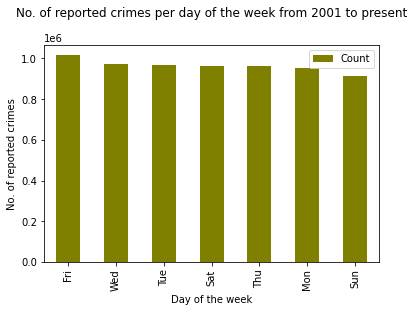

In [33]:
count_df.sort_values('Count', ascending=False).plot(kind='bar', color='olive', x='Day_of_week', y='Count')

plt.xlabel('Day of the week')
plt.ylabel('No. of reported crimes')
plt.title('No. of reported crimes per day of the week from 2001 to present')

ax = plt.gca()
ttl = ax.title
ttl.set_position([.5, 1.1])